In [1]:
import warnings, sys, os

# Hide Python warnings
warnings.filterwarnings("ignore")

# Hide ALL stderr warnings from libraries like jupyter_client
sys.stderr = open(os.devnull, "w")
import logging
logging.disable(logging.CRITICAL)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    accuracy_score, f1_score, classification_report
)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

# For association rules
from mlxtend.frequent_patterns import apriori, association_rules

# reproducibility
RANDOM_STATE = 42

print('libraries imported')


libraries imported


(569, 31)
target
1    357
0    212
Name: count, dtype: int64


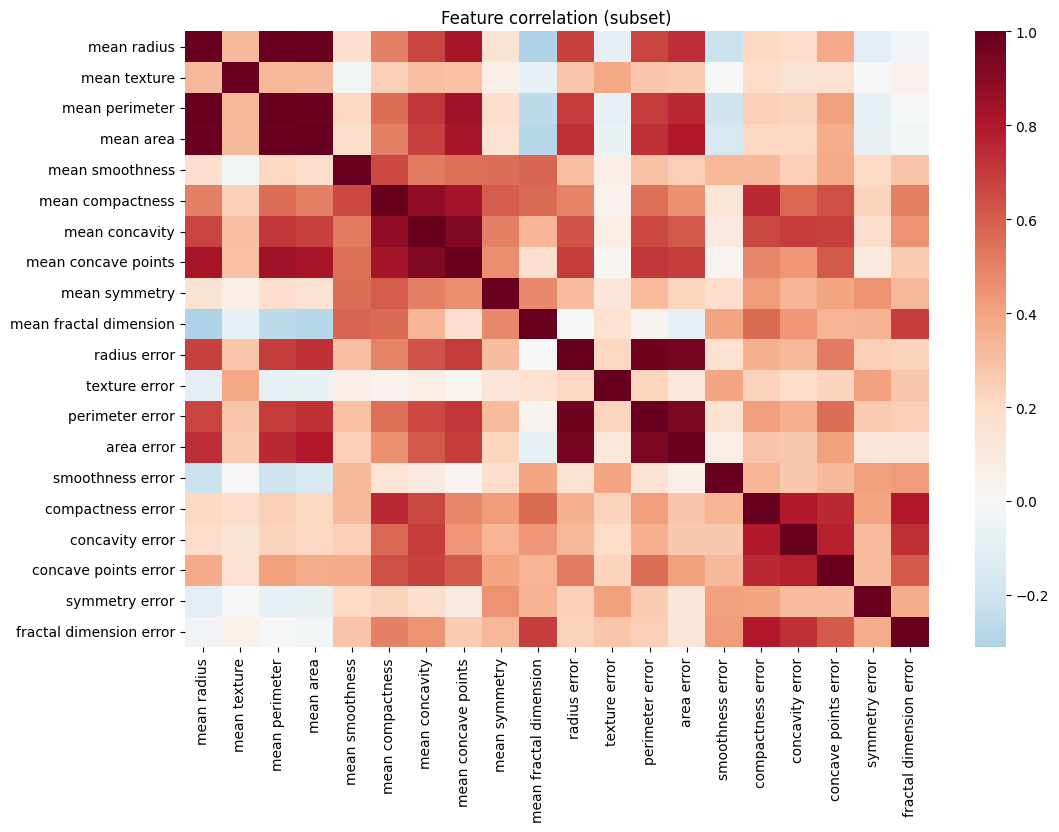

In [3]:
#Load dataset & exploratory data analysis
data = load_breast_cancer(as_frame=True)
df = data.frame.copy()

df['target'] = data.target

df.head()
# Cell: quick EDA
print(df.shape)
print(df['target'].value_counts())
df.describe().T.head()
# Cell: correlation heatmap (top 20 features by variance)
plt.figure(figsize=(12,8))
cols = df.columns[:-1]  # exclude target
corr = df[cols].corr()
# plot only a subset for readability
sns.heatmap(corr.iloc[:20,:20], cmap='RdBu_r', center=0)
plt.title('Feature correlation (subset)')
plt.show()


In [4]:
# Preprocessing
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('train/test shapes:', X_train.shape, X_test.shape)


train/test shapes: (455, 30) (114, 30)


Decision Tree - Accuracy: 0.9122807017543859 F1: 0.9285714285714286


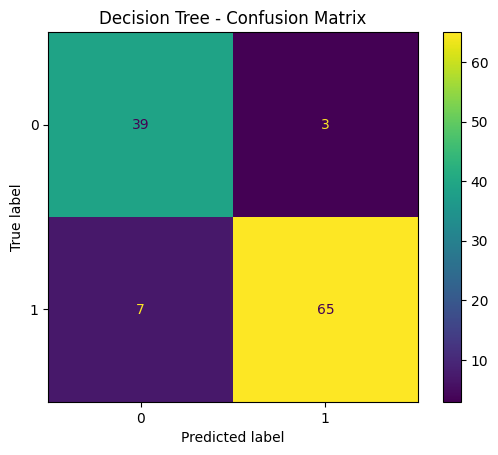

k-NN - Accuracy: 0.956140350877193 F1: 0.9655172413793104


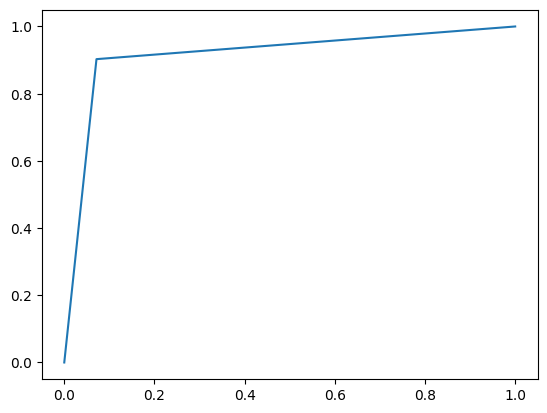

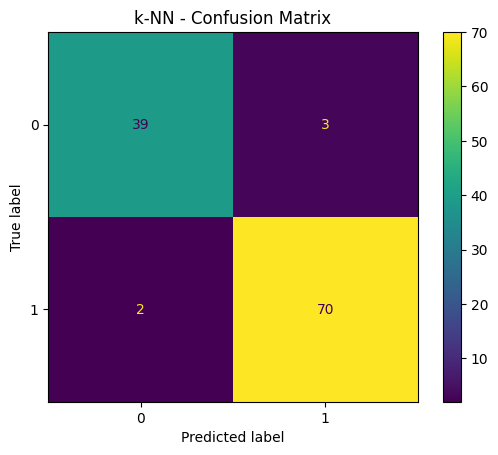

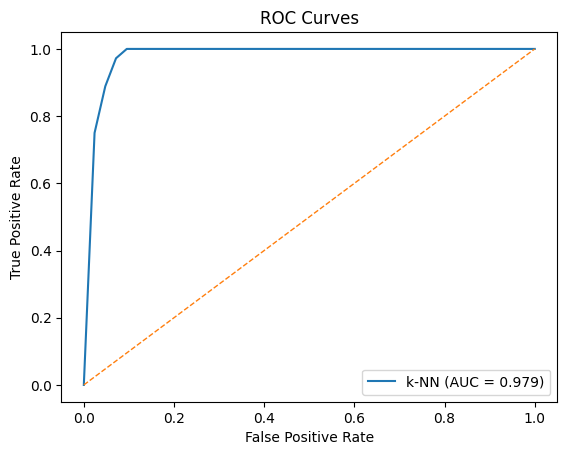

In [5]:
# train decision tree
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(X_train_scaled, y_train)

y_pred_dt = dt.predict(X_test_scaled)

# metrics
acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
print('Decision Tree - Accuracy:', acc_dt, 'F1:', f1_dt)

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(dt, X_test_scaled, y_test)
plt.title('Decision Tree - Confusion Matrix')
plt.show()

# ROC curve
y_proba_dt = dt.predict_proba(X_test_scaled)[:,1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC = {roc_auc_dt:.3f})')

# Cell: k-NN
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
print('k-NN - Accuracy:', acc_knn, 'F1:', f1_knn)

ConfusionMatrixDisplay.from_estimator(knn, X_test_scaled, y_test)
plt.title('k-NN - Confusion Matrix')
plt.show()

# ROC for k-NN
y_proba_knn = knn.predict_proba(X_test_scaled)[:,1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, label=f'k-NN (AUC = {roc_auc_knn:.3f})')

# finish ROC plot
plt.plot([0,1],[0,1],'--',linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


Starting hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'n_estimators': 100, 'max_features': 'log2', 'max_depth': 10}
Best CV F1: 0.9648442513057132
Tuned RF - Test Accuracy: 0.956140350877193
Tuned RF - Test F1: 0.9655172413793104


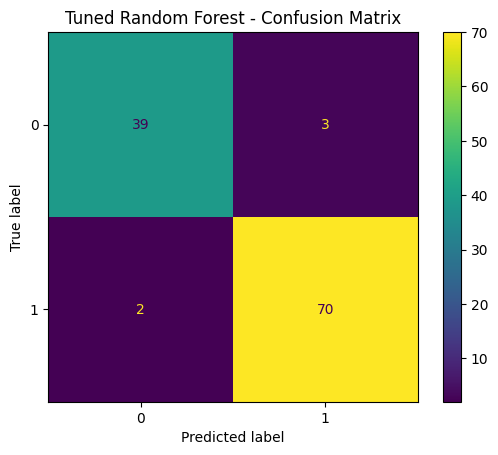

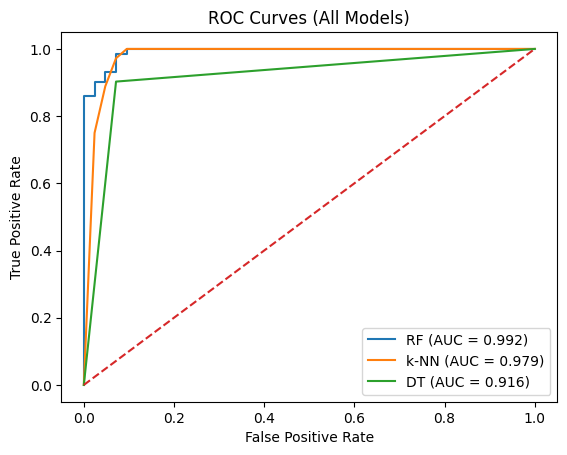

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)

rs = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=3
)

print("Starting hyperparameter tuning...")
rs.fit(X_train_scaled, y_train)

print("Best params:", rs.best_params_)
print("Best CV F1:", rs.best_score_)

best_rf = rs.best_estimator_

# Evaluate
y_pred_rf = best_rf.predict(X_test_scaled)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Tuned RF - Test Accuracy:", acc_rf)
print("Tuned RF - Test F1:", f1_rf)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_rf, X_test_scaled, y_test)
plt.title("Tuned Random Forest - Confusion Matrix")
plt.show()

# ROC curve
y_proba_rf = best_rf.predict_proba(X_test_scaled)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_knn, tpr_knn, label=f'k-NN (AUC = {roc_auc_knn:.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC = {roc_auc_dt:.3f})')
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (All Models)")
plt.legend()
plt.show()


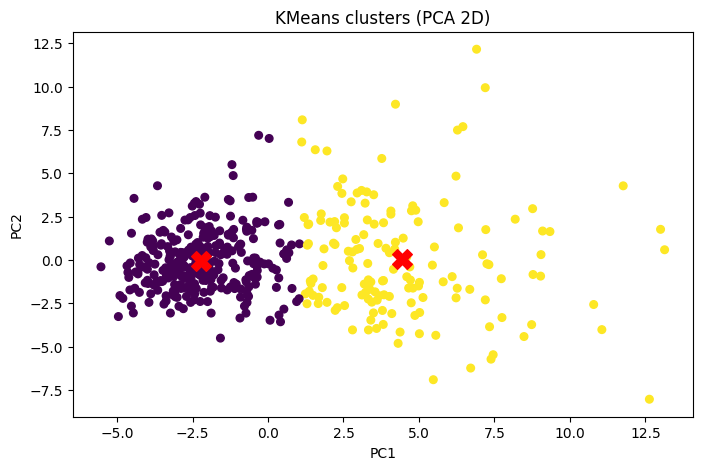

KMeans cluster composition (train set):
       benign(0)  malignant(1)
row_0                         
0             32           272
1            138            13


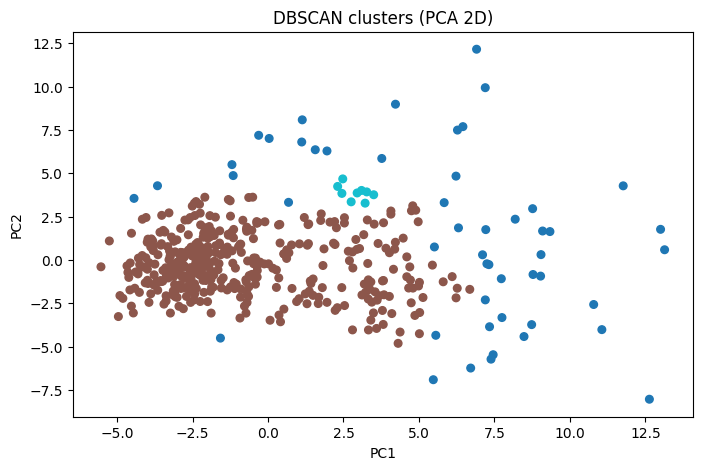

DBSCAN unique labels (including -1 for noise): [-1  0  1]
DBSCAN cluster composition (train set):
       benign(0)  malignant(1)
row_0                         
-1            36            14
 0           128           268
 1             6             3


In [7]:
#PCA to 2D for visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_train_scaled)

# KMeans
kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE)
kmeans_labels = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, cmap='viridis', s=30)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            marker='X', s=200, c='red')
plt.title('KMeans clusters (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# cluster composition
comp = pd.crosstab(index=kmeans_labels, columns=y_train)
comp.columns = ['benign(0)','malignant(1)']
print('KMeans cluster composition (train set):')
print(comp)

# DBSCAN
db = DBSCAN(eps=0.9, min_samples=5)
db_labels = db.fit_predict(X_pca)

plt.figure(figsize=(8,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=db_labels, cmap='tab10', s=30)
plt.title('DBSCAN clusters (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print('DBSCAN unique labels (including -1 for noise):', np.unique(db_labels))

# analyze DBSCAN cluster vs true labels
comp_db = pd.crosstab(index=db_labels, columns=y_train)
comp_db.columns = ['benign(0)','malignant(1)']
print('DBSCAN cluster composition (train set):')
print(comp_db)


In [8]:
#discretize features for association rules
X_full = pd.concat([X, y], axis=1)
# choose a subset of features to keep runtime low
selected_features = ['mean radius','mean texture','mean perimeter','mean area','mean smoothness']

binned = X_full[selected_features].apply(lambda col: pd.cut(col, bins=3, labels=['low','med','high']))
# prefix column names
binned.columns = [f'{c}_bin' for c in binned.columns]

# make one-hot
ohe = pd.get_dummies(binned)
# append target as a categorical item as well
ohe['target_malignant'] = (y==1).astype(int)

# run apriori
freq_items = apriori(ohe, min_support=0.2, use_colnames=True)
print('Frequent itemsets (support >= 0.2):')
print(freq_items.sort_values('support', ascending=False).head(20))

# generate association rules
rules = association_rules(freq_items, metric='confidence', min_threshold=0.6)
rules = rules.sort_values(by=['lift','confidence'], ascending=False)

print('Top rules:')
rules[['antecedents','consequents','support','confidence','lift']].head(20)


Frequent itemsets (support >= 0.2):
     support                                           itemsets
6   0.808436                                (mean area_bin_low)
8   0.639719                          (mean smoothness_bin_med)
9   0.627417                                 (target_malignant)
36  0.625659              (mean area_bin_low, target_malignant)
4   0.602812                           (mean perimeter_bin_low)
28  0.602812        (mean area_bin_low, mean perimeter_bin_low)
0   0.594025                              (mean radius_bin_low)
12  0.594025           (mean radius_bin_low, mean area_bin_low)
11   0.59051      (mean radius_bin_low, mean perimeter_bin_low)
43   0.59051  (mean radius_bin_low, mean area_bin_low, mean ...
2   0.564148                             (mean texture_bin_low)
31  0.550088         (mean perimeter_bin_low, target_malignant)
63  0.550088  (mean area_bin_low, mean perimeter_bin_low, ta...
49  0.537786  (mean radius_bin_low, mean area_bin_low, targe...
15  

,antecedents,consequents,support,confidence,lift
92,(mean perimeter_bin_med),"(mean radius_bin_med, mean smoothness_bin_med)",0.265378,0.740196,2.717236
91,"(mean radius_bin_med, mean smoothness_bin_med)",(mean perimeter_bin_med),0.265378,0.974194,2.717236
86,"(mean radius_bin_med, mean texture_bin_med)",(mean perimeter_bin_med),0.207381,0.967213,2.697766
87,"(mean perimeter_bin_med, mean area_bin_low)",(mean radius_bin_med),0.202109,0.982906,2.675950
9,(mean perimeter_bin_med),(mean radius_bin_med),0.351494,0.980392,2.669106
10,(mean radius_bin_med),(mean perimeter_bin_med),0.351494,0.956938,2.669106
90,"(mean perimeter_bin_med, mean smoothness_bin_med)",(mean radius_bin_med),0.265378,0.974194,2.652230
93,(mean radius_bin_med),"(mean perimeter_bin_med, mean smoothness_bin_med)",0.265378,0.722488,2.652230
85,"(mean perimeter_bin_med, mean texture_bin_med)",(mean radius_bin_med),0.207381,0.967213,2.633226
88,"(mean radius_bin_med, mean area_bin_low)",(mean perimeter_bin_med),0.202109,0.942623,2.629179
